In [57]:
print("""\

.__   __.   ______   .___________.    __      .___________.  ______ .___  ___.    
|  \ |  |  /  __  \  |           |   |  |     |           | /      ||   \/   |    
|   \|  | |  |  |  | `---|  |----`   |  |     `---|  |----`|  ,----'|  \  /  |    
|  . `  | |  |  |  |     |  |        |  |         |  |     |  |     |  |\/|  |    
|  |\   | |  `--'  |     |  |        |  `----.    |  |     |  `----.|  |  |  |    
|__| \__|  \______/      |__|        |_______|    |__|      \______||__|  |__|    
                                                                                  

""")


.__   __.   ______   .___________.    __      .___________.  ______ .___  ___.    
|  \ |  |  /  __  \  |           |   |  |     |           | /      ||   \/   |    
|   \|  | |  |  |  | `---|  |----`   |  |     `---|  |----`|  ,----'|  \  /  |    
|  . `  | |  |  |  |     |  |        |  |         |  |     |  |     |  |\/|  |    
|  |\   | |  `--'  |     |  |        |  `----.    |  |     |  `----.|  |  |  |    
|__| \__|  \______/      |__|        |_______|    |__|      \______||__|  |__|    
                                                                                  






Our strategy:
1. Initial Screen of Nasqaq and NYSE stocks that is greater than $5, and have a marketcap greater than 1B
2. Exclude Stocks that are MEME's and where not merged correctly in WRDS
3. Filter stocks that have a positive Alpha with our regression. 
4. Pair Stocks that Have the Highest Sortino Ratio with the lowest correlation.
5. On the sortino ratio, we are using Adjusted CAPM for the Expected Return of the secutity using Damodaran's ERP
6. Part Stocks that have the largest Market Cap with the lowest correlation
7. Optimize the portoflio with the highest sortino ratio
        
          

In [58]:
import pandas as pd
import numpy as np 
import scipy as sp
import statsmodels.formula.api as smf
import scipy.optimize as sco
from fredapi import Fred
from tickers_list import tickers
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_rows', 10)
plt.style.use('fivethirtyeight')
%matplotlib inline

Here we are cleaning the overall stock data from factset by removing meme stocks and stocks that did not merge correctly with Wharton Wrds data. 


In [59]:
# stock_data = pd.read_csv("Factset_Screen_Data\stock_data.csv") # Initial data import from Factset
stock_data = pd.read_csv("Factset_Screen_Data\S_P_smoked.csv")

# Rename columns Symbol to Ticker
stock_data.rename(columns={'Symbol':'Ticker'}, inplace=True)
# Make Ticker the index
stock_data.set_index('Ticker', inplace=True)

# Remove commas in Recent Closing Price, Market Value, Purchase Price, Common Shares Columns.
stock_data['Purchase Closing Price'] = stock_data['Purchase Closing Price'].str.replace(',', '').astype(float)
stock_data['Recent Closing Price'] = stock_data['Recent Closing Price'].str.replace(',', '').astype(float)
stock_data['Current Market Value'] = stock_data['Current Market Value'].str.replace(',', '').astype(float)
stock_data['Look Back Common Shares'] = stock_data['Look Back Common Shares'].str.replace(',', '').astype(float)
stock_data['Purchase Price Common Shares'] = stock_data['Purchase Price Common Shares'].str.replace(',', '').astype(float)
stock_data['Current Common Shares'] = stock_data['Current Common Shares'].str.replace(',', '').astype(float)


# Removing tickers that are not in the wrds data
bad_tickers = ["BF.B", "BRK.B", "LGF.A", "MOG.A", "AA"]
stock_data = stock_data.drop(bad_tickers, axis=0) # Drop bad tickers


# Removing tickers that are in the do not touch list 
untouchable_tickers = ["GME", "LIN"]
stock_data = stock_data.drop(untouchable_tickers, axis=0) # Drop untouchable tickers

# Drop all rows with NaN values

stock_data.head(26)

,Name,Stock Exchange,RBICS Economy,Lookback Closing Price,Purchase Closing Price,Recent Closing Price,Current Market Value,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares
Ticker,,,,,,,,,,
A,"Agilent Technologies, Inc.",NYSE,Healthcare,42.5,40.9,136.5,40761.8,348.1,335.3,296.0
AAON,"AAON, Inc.",NASDAQ,Industrials,9.0,22.4,63.1,3256.4,55.4,54.5,53.1
AAP,"Advance Auto Parts, Inc.",NYSE,Consumer Cyclicals,76.6,159.3,188.1,10930.1,72.4,73.0,60.1
AAPL,Apple Inc.,NASDAQ,Technology,16.3,27.6,144.8,2400167.0,26106.4,23459.4,16070.8
AAT,"American Assets Trust, Inc.",NYSE,Finance,22.1,39.8,27.2,1673.0,39.3,43.7,60.5
...,...,...,...,...,...,...,...,...,...,...
ADEA,Adeia Inc.,NASDAQ,Consumer Services,19.8,35.8,10.7,1111.5,51.5,52.8,104.3
ADI,"Analog Devices, Inc.",NASDAQ,Technology,39.1,55.5,140.7,72717.6,298.0,311.2,514.3
ADM,Archer-Daniels-Midland Company,NYSE,Consumer Non-Cyclicals,28.6,52.0,94.1,51412.2,668.0,636.7,549.3


Here we are cleaning / formating the wrds data. We are also removing stocks that had NaN values since there was a problem with portfolio return calculation and how np.dot was handeling NaN's. 

We are also removing stocks that are MEME's

In [60]:
untouchable_tickers2 = ["GME", "AA", "LIN"]
df1 = pd.read_csv("Wrds_Data\wrds_smoked_raw.csv")
df2 = df1.pivot_table(index='MthCalDt', columns="Ticker", values="MthPrc", aggfunc='first')
remove_strings_df = df2.apply(lambda x: x.str.replace(',','')) # Brute Force way to remove strings. 

remove_strings_df = remove_strings_df.drop(untouchable_tickers2, axis=1)
# Drop all Nan values from columns

remove_strings_df = remove_strings_df.dropna(axis=1)
remove_strings_df.index = remove_strings_df.index.astype(str)
remove_strings_df.index = pd.to_datetime(remove_strings_df.index)

# Start MthCalDt at 2017-10-31
remove_strings_df = remove_strings_df.loc['2017-10-31':]

remove_strings_df

Ticker,A,AAON,AAP,AAPL,AAT,AAWW,AB,ABC,ABCB,ABG,...,XOM,XPO,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZD,ZION
MthCalDt,,,,,,,,,,,,,,,,,,,,,
2017-10-31,68.03,35,81.74,169.04,38.79,61.35,25.85,76.95,47.9,61.4,...,83.35,69.35,61.07,30.31,66.53,74.45,121.62,115.99,74.14,46.46
2017-11-30,69.24,36.45,101,171.85,39.36,57.75,25,84.82,49.6,65.8,...,83.29,79.03,67.01,29.66,69.34,83.47,117.1,110.32,75.46,49.55
2017-12-29,66.97,36.7,99.69,169.23,38.24,58.65,25.05,91.82,48.2,64,...,83.64,91.59,65.83,29.15,68.2,81.61,120.67,103.8,75.03,50.83
2018-01-31,73.43,36.4,116.99,167.43,35.26,56.3,27.3,99.67,53.55,72.65,...,87.3,94.44,60.81,34.13,72.26,84.59,127.12,123.16,79.99,54.03
2018-02-28,68.59,36.75,114.25,178.12,31.72,60.85,26.6,95.16,53.15,65.85,...,75.74,98.43,56.06,30.32,74.58,81.38,116.25,138.14,74.02,54.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,150.9,78,220.72,165.3,34.4,87.61,50.12,115.75,48.67,163.64,...,59.84,72.44,48.74,18.42,121.11,122.84,119.6,588.78,113.87,63.08
2021-12-31,159.65,79.43,239.88,177.57,37.53,94.12,48.84,132.89,49.68,172.73,...,61.19,77.43,55.79,22.64,119.92,138.86,127.04,595.2,110.86,63.16
2022-01-31,139.32,64.25,231.51,174.78,35.97,80.33,46.95,136.2,49.31,160.97,...,75.96,66.17,53.42,21.11,105.02,125.17,123.02,509.12,105.06,67.82


Here we are converting the cleaned data from a string into a float. The problem is that the data is in String Format where pandas was reading it as '1,560.09'. 

* pt_ret is the arithmetic returns of the stocks
* pt_log is the log returns of the stocks. (Harmonic)

In [61]:
cleaned_data = remove_strings_df.astype(float)
pt_ret = cleaned_data.pct_change(1)[1:]
pt_log = np.log(cleaned_data/cleaned_data.shift(1))[1:]
pt_log.dropna(axis=1, how='all', inplace=True)


Here we are adding market data and damodarans ERP for the stocks since we want a forward looking return to continue to beat the S&P500
* The Risk Free Rate is the 10yr US Treasury Note 
* Equity Risk Premium is the recent damodarn ERP. 

In [62]:
risk_free_rate = 0.0420 # 10 year treasury rate as of 10/23/2022 at 7:09pm (From Bloomberg)
equity_risk_premium = 0.0530 # Damodaran's estimate for October 2022
arth_Sigma = pt_ret.cov() # Covariance Martrix of the arthmatic returns
log_Sigma = pt_log.cov() # Covariance Matrix of the log returns


arth_pt_var = pt_ret.var()*12 # Variance of the arthmatic returns
log_pt_var = pt_log.var()*12 # Variance of the log returns


arth_pt_dvar = pt_ret[pt_ret < 0].var()*12 # Downside Variance of the arthmatic returns
log_pt_dvar = pt_log[pt_log < 0].var()*12 # Downside Variance of the log returns


Here is our regression to get the beta and alpha on each stock.

In [63]:
total_data = pd.DataFrame()
for column in pt_log:
    model = smf.ols(f'{column} ~ IVV', data=pt_log).fit()
    beta = model.params['IVV']
    alpha = model.params['Intercept']
    stderrA = model.bse['Intercept']
    stderrB = model.bse['IVV']
    rsquared = model.rsquared
    stats_data = pd.DataFrame({'Beta': [beta], 'Alpha': [alpha], 'StdErrA': [stderrA], 'StdErrB': [stderrB], 'R-squared':[rsquared]}, index=[column])
    total_data = pd.concat([total_data, stats_data])

total_data.index = total_data.index.rename('Ticker')
capm = ((risk_free_rate + total_data['Beta']) * equity_risk_premium)
adjCapm = ((risk_free_rate + total_data['Beta'] + total_data['Alpha']) * equity_risk_premium)
sharpe_ratio_arth = ((risk_free_rate + capm)/np.sqrt(arth_pt_var))
sharpe_ratio_log = ((risk_free_rate + capm)/np.sqrt(log_pt_var))
sortino_ratio_arth = ((risk_free_rate + capm)/np.sqrt(arth_pt_dvar))
sortino_ratio_log = ((risk_free_rate + capm)/np.sqrt(log_pt_dvar))
total_data['CAPM'] = capm
total_data['AdjCAPM'] = adjCapm
total_data['Sharpe Ratio (Arth)'] = sharpe_ratio_arth
total_data['Sharpe Ratio (Log)'] = sharpe_ratio_log
total_data['Sortino Ratio (Arth)'] = sortino_ratio_arth
total_data['Sortino Ratio (Log)'] = sortino_ratio_log

total_data = total_data.join(stock_data[['Purchase Closing Price', 'Recent Closing Price', 'Look Back Common Shares', 
                                         'Purchase Price Common Shares', 'Current Common Shares', 'Current Market Value']]) # Join the stock data to the total data
total_data = total_data[(total_data['Alpha'] > 0) & (total_data['Beta'] < 3) & (total_data['AdjCAPM'] > risk_free_rate)]
total_data

,Beta,Alpha,StdErrA,StdErrB,R-squared,CAPM,AdjCAPM,Sharpe Ratio (Arth),Sharpe Ratio (Log),Sortino Ratio (Arth),Sortino Ratio (Log),Purchase Closing Price,Recent Closing Price,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares,Current Market Value
Ticker,,,,,,,,,,,,,,,,,
A,1.041522,0.001523,0.006591,0.132995,0.545977,0.057427,0.057507,0.413740,0.416618,0.725801,0.675896,40.9,136.5,348.1,335.3,296.0,40761.8
AAP,1.300051,0.003759,0.010927,0.220490,0.405353,0.071129,0.071328,0.327456,0.327224,0.487251,0.415885,159.3,188.1,72.4,73.0,60.1,10930.1
ABG,1.469076,0.002536,0.014223,0.287008,0.339377,0.080087,0.080221,0.292685,0.285945,0.416407,0.339370,75.9,158.0,31.8,29.8,22.1,3421.8
ACN,1.221561,0.003334,0.005531,0.111600,0.701427,0.066969,0.067145,0.442079,0.441260,0.724901,0.668467,89.3,278.8,640.9,628.1,664.8,186052.9
ADBE,1.023112,0.007201,0.008281,0.167098,0.423657,0.056451,0.056833,0.368194,0.369930,0.669507,0.617219,72.7,318.7,493.8,498.7,464.9,148991.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSO,0.823160,0.002902,0.008475,0.171007,0.312397,0.045853,0.046007,0.339888,0.352326,0.541117,0.495001,107.0,262.7,28.4,30.1,33.2,10187.8
WST,1.020106,0.015589,0.008315,0.167790,0.420206,0.056292,0.057118,0.361907,0.368909,0.551595,0.507528,53.2,221.2,67.4,71.1,74.0,18837.8
WTS,0.979940,0.003359,0.008093,0.163308,0.413839,0.054163,0.054341,0.376976,0.372855,0.510564,0.460467,63.4,138.9,29.4,28.7,27.3,4577.0


Now Here is our Stats Screen where 
1. Take the 100 Largest Soritno Stocks with positive alpha only and pair them to the least correlated stock.
2. Take the 100 Largest Market Cap Stocks and pair them with the least correlated stocks in the data. 


In [64]:
# Here is the Correlation of Returns
correlation_of_arth_returns = pt_ret.corr() # Correlation Matrix of the arthmatic returns
correlation_of_log_returns = pt_log.corr() # Correlation Matrix of the log returns


# Purchase Price has to be less than recent closing price, Alpha Greater than 0 
# data_screen = total_data[total_data['Purchase Closing Price'] < total_data['Recent Closing Price']]
data_screen = total_data

# Here we are getting the larget sortino ratio stocks 
largest_arth_sortino = data_screen.nlargest(100, 'Sortino Ratio (Arth)')
largest_log_sortino = data_screen.nlargest(100, 'Sortino Ratio (Log)')


largest_sortino = largest_log_sortino.head(100)

# Here we are getting the list of the larget sortino ratio stocks
tickers_list_of_largest_sortino = largest_sortino.index.tolist()


lowest_correlation = pd.DataFrame()
for ticker in tickers_list_of_largest_sortino:
    lowest_correlation = pd.concat([lowest_correlation,
     pd.DataFrame({'Ticker': [ticker], 'Paired Tickers': [correlation_of_log_returns[ticker].nsmallest(2).index[1]],
     'Correlation': [correlation_of_log_returns[ticker].nsmallest(2)[1]]})])
large_sortino_lowest_correlation = lowest_correlation
average_correlation = lowest_correlation['Correlation'].mean()


lowest_correlation


,Ticker,Paired Tickers,Correlation
0,MSFT,DAC,-0.174779
0,ORCL,NVAX,-0.183237
0,UNH,CLDX,-0.143469
0,CUZ,KAR,-0.540630
0,ROP,DHT,-0.197034
...,...,...,...
0,AZO,DHT,-0.139415
0,HCA,CSR,-0.110424
0,MELI,THS,-0.159314
0,POOL,SAVA,-0.249352


Here we are taking the top 100 Market Cap Stocks in the NASDAQ & NSYE. 

In [65]:
# Top 50 Largest Market Cap Stocks
largest_market_cap = stock_data.nlargest(100, 'Current Market Value')
largest_market_cap = largest_market_cap[largest_market_cap['Purchase Closing Price'] < largest_market_cap['Recent Closing Price']]
# Remove BRK.B from the list of largest_market_cap
largest_market_cap = largest_market_cap[largest_market_cap.index != 'BRK.B']

ticker_list_of_largest_market_cap = largest_market_cap.index.tolist()
largest_market_cap

,Name,Stock Exchange,RBICS Economy,Lookback Closing Price,Purchase Closing Price,Recent Closing Price,Current Market Value,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares
Ticker,,,,,,,,,,
AAPL,Apple Inc.,NASDAQ,Technology,16.3,27.6,144.8,2400167.0,26106.4,23459.4,16070.8
MSFT,Microsoft Corporation,NASDAQ,Technology,29.5,46.5,226.8,1724369.0,8390.8,8242.9,7454.5
GOOGL,Alphabet Inc. Class A,NASDAQ,Technology,14.5,26.5,92.2,1228010.0,10308.5,5696.3,5973.0
AMZN,"Amazon.com, Inc.",NASDAQ,Consumer Non-Cyclicals,9.7,15.5,111.0,1178293.0,9095.1,9260.1,10187.6
UNH,UnitedHealth Group Incorporated,NYSE,Healthcare,51.8,101.1,541.8,508071.8,1066.0,959.8,935.4
...,...,...,...,...,...,...,...,...,...,...
PGR,Progressive Corporation,NYSE,Finance,20.3,27.0,124.4,71889.5,613.7,587.8,584.8
SO,Southern Company,NYSE,Utilities,45.6,49.1,65.2,71432.6,861.9,899.8,1088.7
DUK,Duke Energy Corporation,NYSE,Utilities,63.9,83.5,91.0,69914.6,444.2,707.0,769.9


Now We are Getting the Largest Market Cap Stocks and pairing it with the least negative in our overall initial screen. 

In [66]:
lowest_correlation = pd.DataFrame()
for ticker in ticker_list_of_largest_market_cap:
    lowest_correlation = pd.concat([lowest_correlation,
     pd.DataFrame({'Ticker': [ticker], 'Paired Tickers': [correlation_of_log_returns[ticker].nsmallest(2).index[1]],
     'Correlation': [correlation_of_log_returns[ticker].nsmallest(2)[1]]})])
large_mkcap_lowest_correlation = lowest_correlation
average_correlation = lowest_correlation['Correlation'].mean()
large_mkcap_lowest_correlation.head(100)


,Ticker,Paired Tickers,Correlation
0,AAPL,CRM,-0.325031
0,MSFT,DAC,-0.174779
0,GOOGL,DHT,-0.258135
0,AMZN,TFSL,-0.159984
0,UNH,CLDX,-0.143469
...,...,...,...
0,PGR,CSR,-0.209873
0,SO,WDFC,-0.197876
0,DUK,DHT,-0.254964
0,HUM,CLDX,-0.102744


Here we are concatinating both datasets with the Highest Sortino and Highest Makret Cap.
If there are Stocks are in both datasets, then we are droping them so they are not repeated. 

In [67]:
# Concatenate large_sortino_lowest_correlation and large_mkcap_lowest_correlation using pd.concat and remove duplicates. 
concat_tickers = pd.concat([large_sortino_lowest_correlation, large_mkcap_lowest_correlation], ignore_index=False).drop_duplicates()
# Set index to Ticker
concat_tickers = concat_tickers.set_index('Ticker')
# Drop GME from the list of concat_tickers in the paired tickers column
cleaned_ticker_list = concat_tickers[concat_tickers['Paired Tickers'] != 'GME']
total_average_correlation = cleaned_ticker_list['Correlation'].mean()
print(f'The Average Total Correlation: {total_average_correlation} \n')
print(cleaned_ticker_list.head(10))

# Create a list of the tickers in concat_tickers from both the Ticker and Paired Tickers columns
total_ticker_list = concat_tickers.index.tolist() + concat_tickers['Paired Tickers'].tolist()

# Filter total_data to only include the tickers in total_ticker_list
filtered_total_data = total_data[total_data.index.isin(total_ticker_list)]
print(f'Total Stocks: {filtered_total_data.shape[0]} \n')
filtered_total_data


The Average Total Correlation: -0.19279194444794606 

       Paired Tickers  Correlation
Ticker                            
MSFT              DAC    -0.174779
ORCL             NVAX    -0.183237
UNH              CLDX    -0.143469
CUZ               KAR    -0.540630
ROP               DHT    -0.197034
JBHT              CSR    -0.155252
SPGI              DHT    -0.160830
ELV               CSR    -0.109702
ICE              SAVA    -0.171303
VOO               DHT    -0.147730
Total Stocks: 112 



,Beta,Alpha,StdErrA,StdErrB,R-squared,CAPM,AdjCAPM,Sharpe Ratio (Arth),Sharpe Ratio (Log),Sortino Ratio (Arth),Sortino Ratio (Log),Purchase Closing Price,Recent Closing Price,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares,Current Market Value
Ticker,,,,,,,,,,,,,,,,,
A,1.041522,0.001523,0.006591,0.132995,0.545977,0.057427,0.057507,0.413740,0.416618,0.725801,0.675896,40.9,136.5,348.1,335.3,296.0,40761.8
ACN,1.221561,0.003334,0.005531,0.111600,0.701427,0.066969,0.067145,0.442079,0.441260,0.724901,0.668467,89.3,278.8,640.9,628.1,664.8,186052.9
ADBE,1.023112,0.007201,0.008281,0.167098,0.423657,0.056451,0.056833,0.368194,0.369930,0.669507,0.617219,72.7,318.7,493.8,498.7,464.9,148991.2
ADI,1.053670,0.000027,0.007917,0.159756,0.460321,0.058071,0.058072,0.376191,0.380582,0.617327,0.564212,55.5,140.7,298.0,311.2,514.3,72717.6
ADP,0.842875,0.003743,0.006931,0.139856,0.415950,0.046898,0.047097,0.405462,0.401761,0.526372,0.488400,83.4,235.0,488.7,482.1,415.3,97651.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VOO,0.998028,0.000077,0.000135,0.002723,0.999620,0.055121,0.055126,0.576556,0.574654,0.810793,0.761470,NaN,NaN,NaN,NaN,NaN,NaN
VRSN,0.901096,0.004175,0.006690,0.134986,0.466314,0.049984,0.050205,0.409536,0.411716,0.660348,0.617688,57.0,185.8,159.4,121.1,107.3,19846.3
WIRE,1.139971,0.005414,0.010858,0.219102,0.346743,0.062644,0.062931,0.307101,0.319259,0.521560,0.471705,37.3,139.0,23.4,20.7,19.1,2724.6


Here were are going to do the post modern portfolio theory where we are going to create an optimized portfolio with the highest sortino ratio.

In [68]:
expectedReturn = filtered_total_data['CAPM']
# Get the downside covariance matix  less than 0 from pt_log with the ticker in filtered total data
downside_covariance = pt_log[pt_log < 0]
Sigma = downside_covariance[filtered_total_data.index].cov()*12

# Here is the bound for the minimum and maximum weights for each stock.
min_weight = 0.001
max_weight = 0.08

# Here is the number of simulations of the stocks
num_port = 1000000



def portfolio_annualised_performance(weights, expectedReturns, Sigma):
    returns = np.sum(expectedReturns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return std, returns

def neg_sortino_ratio(weights, expectedReturns, Sigma, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, expectedReturns, Sigma)
    return -(p_ret - risk_free_rate) / p_var

def max_sortino_ratio(expectedReturns, Sigma, risk_free_rate):
    num_assets = len(expectedReturns)
    args = (expectedReturns, Sigma, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (min_weight,max_weight)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(neg_sortino_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, expectedReturns, Sigma):
    return portfolio_annualised_performance(weights, expectedReturns, Sigma)[0]

def min_variance(expectedReturns, Sigma):
    num_assets = len(expectedReturns)
    args = (expectedReturns, Sigma)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (min_weight,max_weight)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result


def display_ef_with_selected(expectedReturns, Sigma, risk_free_rate):
    max_sortino = max_sortino_ratio(expectedReturns, Sigma, risk_free_rate)
    max_sortino_allocation = pd.DataFrame({"+SortinoWeight":max_sortino.x})

    min_vol = min_variance(expectedReturns, Sigma)
    min_vol_allocation = pd.DataFrame({'-VolWeight':min_vol.x})

    
    wWeight = np.zeros((num_port,len(expectedReturns)))
    expectedReturn = np.zeros(num_port)
    expectedVolatility = np.zeros(num_port)
    sortinoRatio = np.zeros(num_port)

    markowiz_dataframe = pd.DataFrame()
    for k in range(num_port):
        # Generate random weight vector
        w = np.array(np.random.random(len(expectedReturns)))
        w = w / np.sum(w)
        wWeight[k,:] = w
        expectedReturn[k] = np.sum((expectedReturns * w))
        expectedVolatility[k] = np.sqrt(np.dot(w.T,np.dot(Sigma, w)))
        sortinoRatio[k] = expectedReturn[k]/expectedVolatility[k]

    maxIndex = sortinoRatio.argmax()
    lmx = wWeight[maxIndex,:]
    bruteAllocation = pd.DataFrame({'bruteAllocation': lmx})


    # Concatenate the max_sortino_allocation, min_vol_allocation, and bruteAllocation DataFrames
    markowiz_dataframe = pd.concat([max_sortino_allocation, bruteAllocation], axis=1)

    # Concatenate the filtered_total_data and markowiz_dataframe DataFrames on the filtered_total_data index
    markowiz_dataframe = pd.concat([filtered_total_data.reset_index(), markowiz_dataframe],axis=1)
    markowiz_dataframe = markowiz_dataframe.set_index('Ticker')
    

    return markowiz_dataframe
    

efficent_frontier_data = display_ef_with_selected(expectedReturn, Sigma, risk_free_rate)



# Check to See if the Data sums to 1
print(f"To Check if Summed to One: {efficent_frontier_data[['+SortinoWeight']].sum().to_string()}")
print(f"To Check if Summed to One: {efficent_frontier_data[['bruteAllocation']].sum().to_string()} \n")


portfolio_expected_return_Scipy = np.sum(efficent_frontier_data['CAPM']*efficent_frontier_data['+SortinoWeight'])
portfolio_expected_return_brute = np.sum(efficent_frontier_data['CAPM']*efficent_frontier_data['bruteAllocation'])

portfolio_volatility_Scipy = np.sqrt(np.dot(efficent_frontier_data['+SortinoWeight'].T,np.dot(Sigma, efficent_frontier_data['+SortinoWeight'])))
portfolio_volatility_brute = np.sqrt(np.dot(efficent_frontier_data['bruteAllocation'].T,np.dot(Sigma, efficent_frontier_data['bruteAllocation'])))


print(f"Portfolio Expected Return Scipy: {round(portfolio_expected_return_Scipy, 3)*100}%")
print(f"Portfolio Expected Return Brute: {round(portfolio_expected_return_brute, 3)*100}%")



# Sort by brite force allocation for the largest weights
sorted_brute_allocation = efficent_frontier_data.sort_values(by=['bruteAllocation'], ascending=False)
sorted_brute_allocation.to_csv('Output_Attribution/highest_sortino_stocks.csv')
sorted_brute_allocation

c:\Users\Trevor Seibert\Desktop\DevProj\University\Popova_Project\not_ltcm\env\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


To Check if Summed to One: +SortinoWeight    1.0
To Check if Summed to One: bruteAllocation    1.0 

Portfolio Expected Return Scipy: 6.800000000000001%
Portfolio Expected Return Brute: 6.0%


,Beta,Alpha,StdErrA,StdErrB,R-squared,CAPM,AdjCAPM,Sharpe Ratio (Arth),Sharpe Ratio (Log),Sortino Ratio (Arth),Sortino Ratio (Log),Purchase Closing Price,Recent Closing Price,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares,Current Market Value,+SortinoWeight,bruteAllocation
Ticker,,,,,,,,,,,,,,,,,,,
ATRC,1.040509,0.010100,0.014172,0.285979,0.206078,0.057373,0.057908,0.248705,0.256068,0.610092,0.556904,20.0,40.5,16.2,27.5,46.4,1928.5,0.080,0.018476
MCO,1.207151,0.003490,0.005747,0.115957,0.679999,0.066205,0.066390,0.436453,0.436572,0.757953,0.706978,95.8,261.0,222.0,208.6,183.2,47076.9,0.001,0.018437
KLIC,1.206957,0.004303,0.012889,0.260086,0.296894,0.066195,0.066423,0.274756,0.288490,0.698360,0.635615,14.5,40.8,73.7,77.0,58.1,2446.4,0.001,0.018183
FR,0.963730,0.002917,0.005603,0.113067,0.587546,0.053304,0.053458,0.445342,0.447705,0.727995,0.681270,20.6,47.1,86.6,110.6,132.1,6331.3,0.001,0.018130
VRSN,0.901096,0.004175,0.006690,0.134986,0.466314,0.049984,0.050205,0.409536,0.411716,0.660348,0.617688,57.0,185.8,159.4,121.1,107.3,19846.3,0.001,0.018056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMRC,0.912820,0.034380,0.020101,0.405604,0.090339,0.050605,0.052428,0.172359,0.180097,0.281521,0.227351,7.0,60.1,25.4,28.4,33.8,3162.4,0.001,0.000541
WM,0.885134,0.003021,0.005134,0.103598,0.588707,0.049138,0.049298,0.466695,0.466613,0.671098,0.620177,51.3,158.3,460.3,457.9,410.5,65664.0,0.001,0.000541
NVMI,1.149186,0.011374,0.010054,0.202886,0.386157,0.063133,0.063736,0.329679,0.335774,0.629732,0.570291,10.4,73.1,26.3,27.1,28.7,2115.3,0.080,0.000128


In [77]:



benchmark_returns = pt_ret['IVV']
# Create Dataframe for benchmark_returns and the column name is Benchmark
benchmark_returns = pd.DataFrame(benchmark_returns)  # Create Dataframe for benchmark_returns and the column name is Benchmark
benchmark_returns.columns = ['Benchmark']  # Rename the column name to Benchmark


# filter pt_retuns that matches tickers in sorted_brute_allocation index Ticker
filtered_pt_ret = pt_ret[sorted_brute_allocation.index]


portfolio_annual_returns = np.dot(filtered_pt_ret, sorted_brute_allocation['bruteAllocation']) # Portfolio returns

# Create Dataframe that matches the MthCalDt from pt_ret with the portfolio_annual_retuns
portfolio_annual_returns = pd.DataFrame(portfolio_annual_returns, index=pt_ret.index, columns=['Portfolio'])

# Concatinate portfolio_annual_returns with benchmark_returns on the index MthCalDt
portfolio_annual_returns = pd.concat([portfolio_annual_returns, benchmark_returns], axis=1) 

# Make the index  MthCalDt a date time formate Year-Month-Day
portfolio_annual_returns.index = portfolio_annual_returns.index.astype(str)  
portfolio_annual_returns.index = pd.to_datetime(portfolio_annual_returns.index)  



portfolio_average_reteurn = portfolio_annual_returns["Portfolio"].mean()*12 # Portfolio Average Return
benchmark_average_return = portfolio_annual_returns["Benchmark"].mean()*12 # Benchmark Average Return
correlation_of_portfolio_and_benchmark = portfolio_annual_returns["Portfolio"].corr(portfolio_annual_returns["Benchmark"]) # Correlation of Portfolio and Benchmark


# Benchmark Average Return & Portfolio Beta
portfolio_beta = round(np.sum(np.dot(sorted_brute_allocation['bruteAllocation'].T, sorted_brute_allocation['Beta'])),2) # Portfolio Beta
portfolio_alpha = round(np.sum(np.dot(sorted_brute_allocation['bruteAllocation'].T, sorted_brute_allocation['Alpha'])),3) # Portfolio Alpha



print(f"Average Annnualized Portfolio Returns: {round(portfolio_average_reteurn, 2)*100}%")  # Print the portfolio_annual_returns
print(f"Average Annualized Benchmark Returns: {round(benchmark_average_return, 1)*100}%")  # Print the portfolio_average_reteurn
print(f"Correlation of Portfolio and Benchmark: {round(correlation_of_portfolio_and_benchmark,2)}")  # Print the correlation_of_portfolio_and_benchmark


portfolio_annual_returns.to_csv('Output_Attribution/portfolio_arth_returns.csv')
portfolio_annual_returns


Average Annnualized Portfolio Returns: 30.0%
Average Annualized Benchmark Returns: 10.0%
Correlation of Portfolio and Benchmark: 0.91


,Portfolio,Benchmark
MthCalDt,,
2017-11-30,0.040356,0.031220
2017-12-29,0.003446,0.007344
2018-01-31,0.056461,0.056909
2018-02-28,-0.023435,-0.038043
2018-03-29,0.000826,-0.029158
...,...,...
2021-11-30,0.000290,-0.007289
2021-12-31,0.050914,0.042305
2022-01-31,-0.091302,-0.052873


<AxesSubplot: title={'center': 'Portfolio vs. Benchmark Arithmetic Returns'}, xlabel='MthCalDt'>

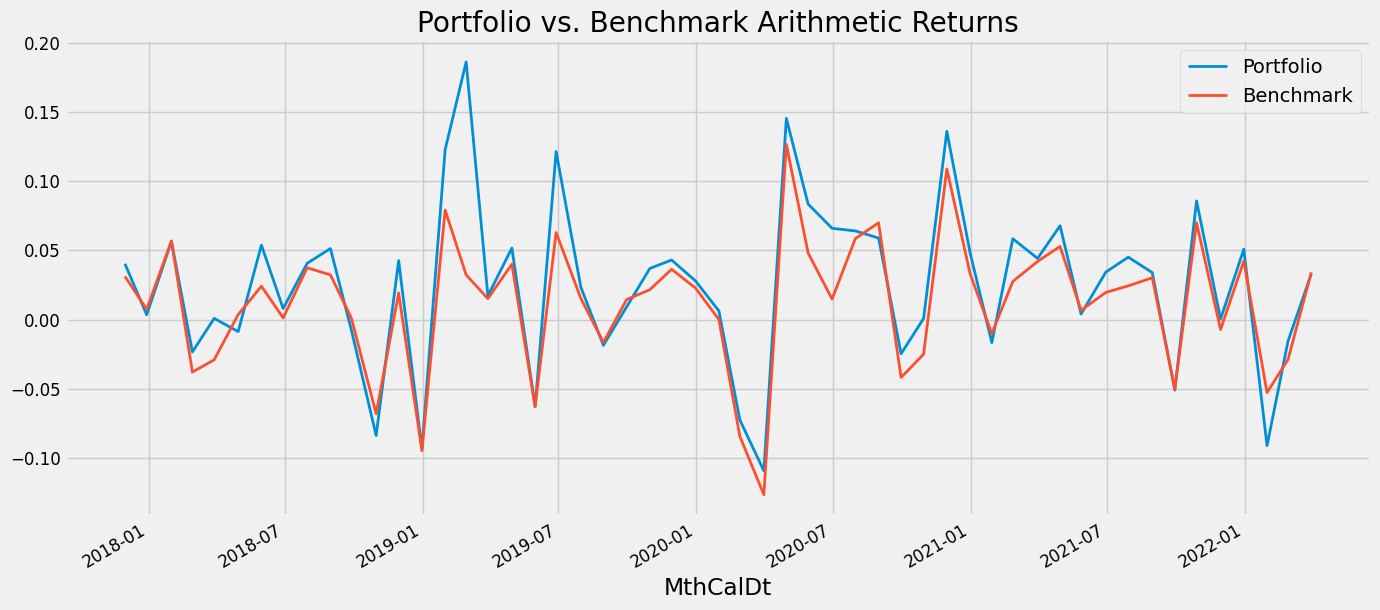

In [70]:
# Line Plot of the portfolio_annual_returns and the benchmark_returns. X axis is the Index MthCalDt and Y axis is the returns
portfolio_annual_returns.plot(figsize=(15, 7), title='Portfolio vs. Benchmark Arithmetic Returns', fontsize=12, linewidth=2.0)



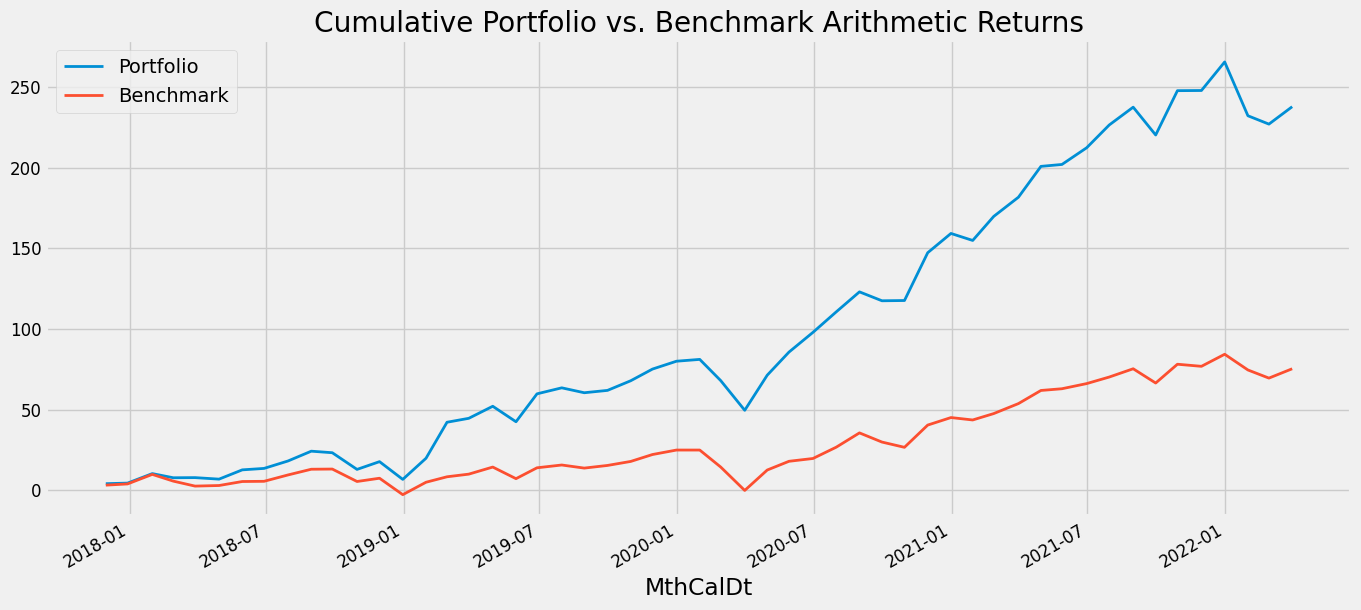

In [71]:
# Graph portfolio_cumulative_return for both the portfolio and benchmark


cumulative_returns = np.cumprod(1 + portfolio_annual_returns) - 1
convert_to_percent = cumulative_returns * 100
convert_to_percent.plot(figsize=(15, 7), title='Cumulative Portfolio vs. Benchmark Arithmetic Returns', fontsize=12, linewidth=2.0)
convert_to_percent.to_csv('Output_Attribution/cumulative_returns.csv')


In [72]:
benchmark_returns = pt_log['IVV']
# Create Dataframe for benchmark_returns and the column name is Benchmark
benchmark_returns = pd.DataFrame(benchmark_returns)  # Create Dataframe for benchmark_returns and the column name is Benchmark
benchmark_returns.columns = ['Benchmark']  # Rename the column name to Benchmark


# filter pt_retuns that matches tickers in sorted_brute_allocation index Ticker
filtered_pt_ret = pt_log[sorted_brute_allocation.index]

# Replace NaN with 0 in filtered_pt_ret
filtered_pt_ret2 = filtered_pt_ret.fillna(0)  

portfolio_annual_log_returns = np.dot(filtered_pt_ret2, sorted_brute_allocation['bruteAllocation']) # Portfolio returns

# Create Dataframe that matches the MthCalDt from pt_ret with the portfolio_annual_retuns
portfolio_annual_log_returns = pd.DataFrame(portfolio_annual_log_returns, index=pt_log.index, columns=['Portfolio'])

# Concatinate portfolio_annual_returns with benchmark_returns on the index MthCalDt
portfolio_annual_log_returns = pd.concat([portfolio_annual_log_returns, benchmark_returns], axis=1) 

# Make the index  MthCalDt a date time formate Year-Month-Day
portfolio_annual_log_returns.index = portfolio_annual_log_returns.index.astype(str)  
portfolio_annual_log_returns.index = pd.to_datetime(portfolio_annual_log_returns.index)  



portfolio_average_reteurn = portfolio_annual_log_returns["Portfolio"].mean()*12 # Portfolio Average Return
benchmark_average_return = portfolio_annual_log_returns["Benchmark"].mean()*12 # Benchmark Average Return
correlation_of_portfolio_and_benchmark_log = portfolio_annual_log_returns["Portfolio"].corr(portfolio_annual_log_returns["Benchmark"]) # Correlation of Portfolio and Benchmark

  # Benchmark Average Return

print(f"Average Portfolio Returns: {round(portfolio_average_reteurn,2)*100}%")  # Print the portfolio_annual_returns
print(f"Average Benchmark Returns: {round(benchmark_average_return,2)*100}%")  # Print the portfolio_average_reteurn
print(f"Correlation of Portfolio and Benchmark: {round(correlation_of_portfolio_and_benchmark_log,2)}")  # Print the correlation_of_portfolio_and_benchmark


portfolio_annual_log_returns.to_csv("Output_Attribution\portfolio_log_returns.csv")
portfolio_annual_log_returns

Average Portfolio Returns: 22.0%
Average Benchmark Returns: 13.0%
Correlation of Portfolio and Benchmark: 0.96


,Portfolio,Benchmark
MthCalDt,,
2017-11-30,0.036355,0.030742
2017-12-29,0.002053,0.007317
2018-01-31,0.052917,0.055349
2018-02-28,-0.025380,-0.038786
2018-03-29,-0.000703,-0.029591
...,...,...
2021-11-30,-0.002799,-0.007315
2021-12-31,0.047723,0.041435
2022-01-31,-0.098077,-0.054322


<AxesSubplot: title={'center': 'Portfolio vs. Benchmark Log Returns'}, xlabel='MthCalDt'>

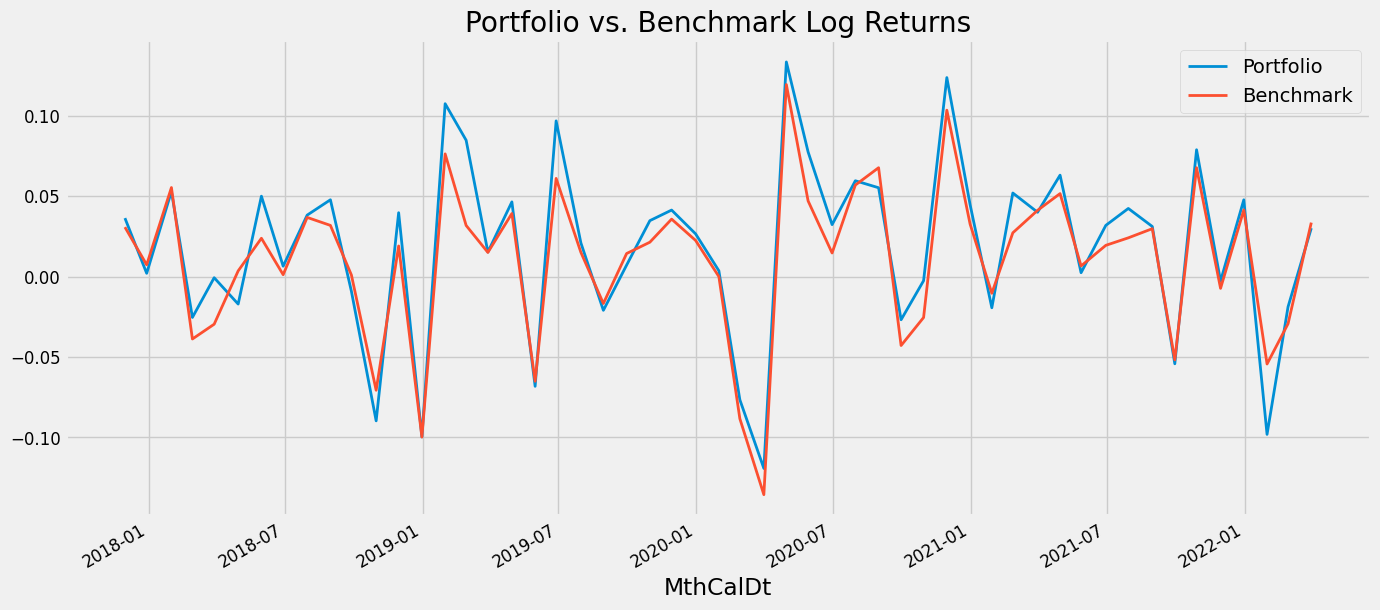

In [73]:
# Log Returns
portfolio_annual_log_returns.plot(figsize=(15, 7), title='Portfolio vs. Benchmark Log Returns', fontsize=12, linewidth=2.0)


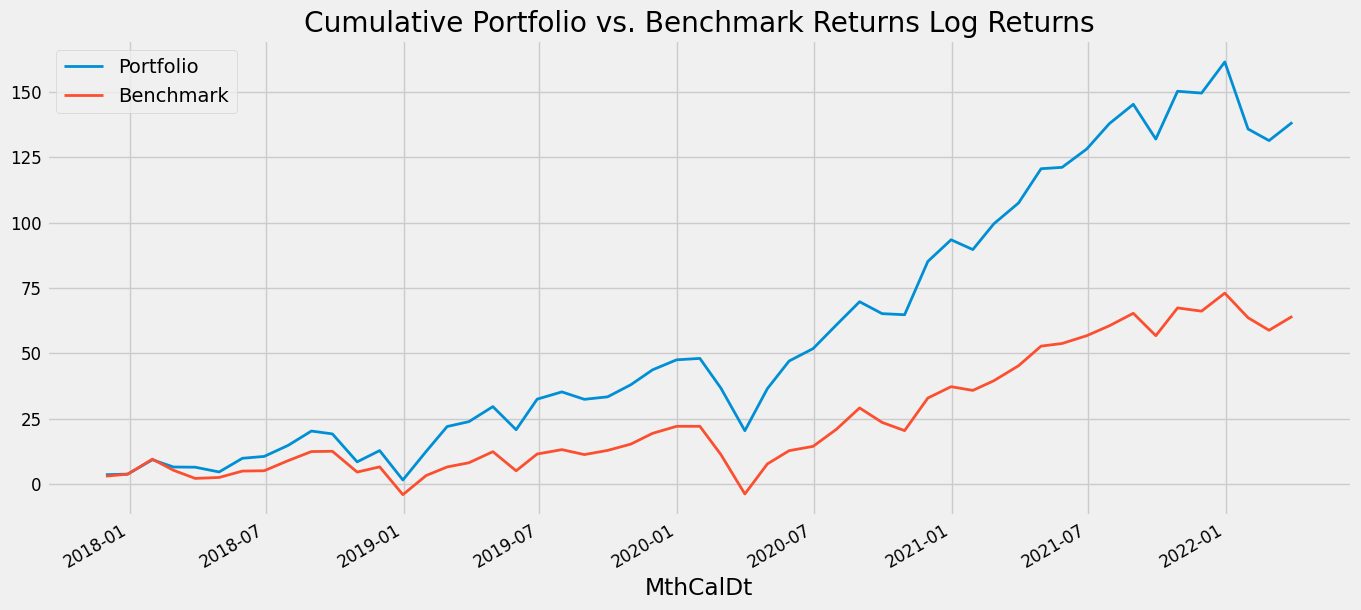

In [74]:
cumulative_log_returns = np.cumprod(1 + portfolio_annual_log_returns) -1
convert_to_percent_log = cumulative_log_returns * 100
convert_to_percent_log.plot(figsize=(15, 7), title='Cumulative Portfolio vs. Benchmark Returns Log Returns', fontsize=12, linewidth=2.0)
convert_to_percent_log.to_csv('Output_Attribution/cumulative_log_returns.csv')

Final Stats for the Portfolio

In [76]:
portfolio_sotino_ratio = (portfolio_average_reteurn - risk_free_rate)/portfolio_volatility_brute
portfolio_treynor_ratio = (portfolio_average_reteurn - risk_free_rate)/portfolio_beta

print(f"Portfolio Beta: {portfolio_beta}")
print(f"Portfolio Alpha: {portfolio_alpha}")
print(f"Portfolio Sortino Ratio: {round(portfolio_sotino_ratio,2)}")
print(f"Portfolio Treynor Ratio: {round(portfolio_treynor_ratio,2)}")


Portfolio Beta: 1.08
Portfolio Alpha: 0.007
Portfolio Sortino Ratio: 1.78
Portfolio Treynor Ratio: 0.16
